In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('poster', font_scale=1.25)

In [6]:
import findspark as fs

In [7]:
fs.init()

In [8]:
import pyspark as ps

In [9]:
# Assumes local options are already set!
config = ps.SparkConf()
config = config.setAppName('wiki_solver')

In [10]:
sc = ps.SparkContext(conf=config)

In [11]:
num_partitions_to_use=50

# Graph work

In [14]:
links_raw_data = sc.textFile('links-simple-sorted.txt', minPartitions=num_partitions_to_use)
titles_raw_data = sc.textFile('titles-sorted.txt', minPartitions=num_partitions_to_use)

Ugh. So we need to make a network out of this gigantic dataset. Let's get started. Luckily we can prototype my code locally & deploy on the cluster.

In [15]:
import re

In [16]:
def get_links(x):
    split = re.findall(r"[\w']+", x)
    name = int(split[0])
    linked_to = split[1:]
    linked_to = [int(z) for z in linked_to]
    return (name, linked_to)

In [17]:
all_links = links_raw_data.map(get_links)

In [18]:
all_links.take(2)

[(1, [1664968]), (2, [3, 747213, 1664968, 1691047, 4095634, 5535664])]

Good. This is what we need...it would be better if we could get the titles though. I guess that's not a big deal though. To link to the titles...how do we do that? Probably reduce by key. BLEHHH

We need to remember that the titles are **1-indexed.**

In [19]:
titles_raw_data.take(5)

[u'!', u'!!', u'!!!', u'!!!!', u'!!!Fuck_You!!!']

Ok this is reasonably hilarious. lol. I guess the list was not pruned of innapropriate stuff! :D 

In [20]:
titles_with_index_offset = titles_raw_data.zipWithIndex()

In [21]:
index_then_title = titles_with_index_offset.map(lambda x: (x[1] + 1, x[0])) # One indexed!
title_then_index = index_then_title.map(lambda x: (x[1], x[0]))

In [22]:
network_rdd = all_links

Let us actually do some optimization first. Notably sorting by key.

Looks pretty good. Nice.

In [23]:
network_rdd.is_cached

False

If it's cached my computer will explode. Not enough memory :( 

In [24]:
from HW1.network_commands import Path_Finder

We need to look up the start and finish nodes.

In [25]:
start_node = title_then_index.lookup('Harvard_University')[0]
end_node = title_then_index.lookup('Kevin_Bacon')[0]

In [28]:
title_then_index = title_then_index.sortByKey(numPartitions=num_partitions_to_use).cache()
index_then_title = index_then_title.sortByKey(numPartitions=num_partitions_to_use).cache()

## For now we will use the marvel situation to test

In [13]:
import cPickle as pkl

In [16]:
with open('marvel_network.pkl', 'rb') as fi:
    network_rdd_raw = pkl.load(fi)

In [17]:
network_rdd = sc.parallelize(network_rdd_raw, 50).sortByKey(numPartitions=50).cache()

In [62]:
network_rdd.is_cached

True

In [63]:
from HW1.network_commands import Path_Finder

In [64]:
Path_Finder.num_partitions = num_partitions_to_use

In [65]:
finder = Path_Finder(sc, network_rdd, 'CAPTAIN AMERICA', 'blerp')

Great.

In [68]:
finder.do_iteration()

In [69]:
finder.distance_rdd.collect()

[(u'POLARIS DOPPELGANGER', (1, [u'CAPTAIN AMERICA'])),
 (u'GENESIS/TYLER DAYSPR',
  (2,
   [u'GUARDIAN/JAMES MACDO',
    u'ANGEL/WARREN KENNETH',
    u'MR. SINISTER/NATHAN ',
    u'THUNDERBIRD II/JAMES',
    u'EXPEDITER II/ZOE CUL',
    u'BOOMER/TABITHA SMITH',
    u'FERAL/MARIA CALLASAN',
    u'CYCLOPS/SCOTT SUMMER',
    u'STORM/ORORO MUNROE S',
    u'DUBOIS, NOAH',
    u'BARRAGE',
    u'GIDEON',
    u'WOLVERINE/LOGAN ',
    u'HUDSON, HEATHER',
    u'BRIDGE, GEORGE WASHI',
    u'CANNONBALL II/SAM GU',
    u'SUMMERS, NATHAN CHRI',
    u'HARDRIVE',
    u'FURY, COL. NICHOLAS ',
    u'SUNSPOT/ROBERTO DACO',
    u'COPYCAT/VANESSA',
    u'APOCALYPSE/EN SABAH ',
    u'STRYFE',
    u'BEAST/HENRY &HANK& P',
    u'SHATTERSTAR II/GAVEE',
    u'CALIBAN/',
    u'GAUNTLET',
    u'FOXBAT',
    u'DOMINO III/BEATRICE/',
    u'MARVEL GIRL/JEAN GRE',
    u'ELEKTRA/ELEKTRA NATC'])),
 (u'PARKER, MARY',
  (2,
   [u'SPIDER-MAN/PETER PAR',
    u'ROBERTSON, JOE',
    u'THING/BENJAMIN J. GR',
    u'JAMESON, J.

In [27]:
finder.run_until_converged()

1


TypeError: 'PipelinedRDD' object is not iterable

BOOM BABY IT WORKS I'M DA KING OF THE WORLD!

Very cool. The nodes are connected. Let's get a path! The only thing I am screwing up is the lookup...fuck! lol

In [82]:
path = finder.collected_distance_rdd

In [83]:
len(path)

483038

Holy crap that's a lot of data. lol. We now need to work with this and get the path back.

In [84]:
path_rdd = sc.parallelize(path, num_partitions_to_use)

Cool. We now trace the path back.

In [85]:
index_then_title.lookup(start_node)

[u'Bob_Saget']

In [108]:
chosen_parent = end_node
path_back = [end_node]

go = True
while go:
    potential_parents = path_rdd.lookup(chosen_parent)[0][1]
    # Let's make the parent choice random to get variability
    chosen_parent = np.random.choice(potential_parents)
    path_back.append(chosen_parent)
    if chosen_parent == start_node:
        go = False
path_forwards = list(reversed(path_back))

We now translate the path into actual words. We assume it won't take too long...wait what's the fastest way to do this?

This doesn't look right. I'm confused.

In [109]:
path_forwards_names = [index_then_title.lookup(z)[0] for z in path_forwards]

In [110]:
path_forwards_names

[u'Bob_Saget',
 u'Musical_theatre',
 u'South_Park:_Bigger,_Longer_&_Uncut',
 u'Satan']

# Old stuff

In [19]:
marvel_raw_data.take(10)

[u'"FROST, CARMILLA","AA2 35"',
 u'"KILLRAVEN/JONATHAN R","AA2 35"',
 u'"M\'SHULLA","AA2 35"',
 u'"24-HOUR MAN/EMMANUEL","AA2 35"',
 u'"OLD SKULL","AA2 35"',
 u'"G\'RATH","AA2 35"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 35"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 36"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 37"',
 u'"HUMAN ROBOT","WI? 9"']

In [20]:
def get_issue_character(raw_line):
    dat = raw_line.split('"')
    character_name = dat[1]
    issue = dat[3]
    return (issue, character_name)

In [21]:
issue_character_rdd = marvel_raw_data.map(get_issue_character)

Links are symmetric. We can just create key/value pairs from this. We want character as a key, values as everyone they link to. If one character links to another, the other character *must* link to them!

In [22]:
issue_groups_rdd = issue_character_rdd.groupByKey()

In [23]:
muffin = [(2,3),(4,5)]

In [24]:
def get_links_from_groups(x):
    list_of_characters = list(x[1])
    links = []
    for cur_character in list_of_characters:
        for other_character in list_of_characters:
            if cur_character != other_character:
                # Ensure that links are symmetric
                links.append((cur_character, other_character))
                links.append((other_character, cur_character))
    return tuple(links)

In [25]:
all_links_rdd = issue_groups_rdd.flatMap(get_links_from_groups)

We now groupby key again. And then we have all the links for a given individual. *But* we have to make sure they are unique.

In [26]:
all_links_rdd.take(2)

[(u'PRINCESS ZANDA', u"BLACK PANTHER/T'CHAL"),
 (u"BLACK PANTHER/T'CHAL", u'PRINCESS ZANDA')]

In [27]:
character_and_links_rdd = all_links_rdd.groupByKey()

In [28]:
def cleanup_links(x):
    linked_to = list(x[1])
    unique_links = tuple(set(linked_to))
    return (x[0], unique_links)

In [29]:
character_and_links_rdd.take(1)

[(u'QUESADA, JOE', <pyspark.resultiterable.ResultIterable at 0x7fb35ff868d0>)]

In [30]:
network_rdd = character_and_links_rdd.map(cleanup_links)

Ok, awesome. We are all set.

In [31]:
network_result = network_rdd.collect()

In [32]:
network_result[0:5]

[(u'QUESADA, JOE',
  (u'ZURI',
   u'GLADIATOR/MELVIN POT',
   u'SMITH, KEVIN',
   u'OKOYE',
   u'PALMIOTTI, JIMMY',
   u'MARTINEZ, ALITHA',
   u'MYSTERIO/QUENTIN BEC',
   u'WATSON-PARKER, MARY ',
   u'SPIDER-MAN/PETER PAR',
   u'MCKENZIE, LYDIA',
   u'LAMY, KELLY',
   u'URICH, BEN',
   u"BLACK PANTHER/T'CHAL",
   u'MR. FANTASTIC/REED R',
   u'THING/BENJAMIN J. GR',
   u'QUINN, ASHLEY',
   u'CAPTAIN AMERICA',
   u'MALICE V/NAKIA',
   u'NELSON, CANDACE',
   u'INVISIBLE WOMAN/SUE ',
   u'BUTCH',
   u'EIGHTBALL',
   u'DAREDEVIL/MATT MURDO',
   u'ROSS, EVERETT KENNET',
   u'POTTER, BETSY BEATTY',
   u'BLACK WIDOW/NATASHA ',
   u'EVERETT, BILL',
   u'BLAKE, BECKY',
   u'DAKESIAN, NANCI',
   u'SHARPE, ROSALINDE',
   u'NELSON, FRANKLIN FOG',
   u'MILLER, FRANK',
   u'HUMAN TORCH/JOHNNY S',
   u'OSBORN, LIZ ALLAN',
   u'DR. STRANGE/STEPHEN ',
   u'DARLA',
   u'RALF',
   u'PAGE, KAREN',
   u'LEE, STAN')),
 (u'CRUSADER II/ARTHUR B',
  (u'HELA [ASGARDIAN]',
   u'X-MAN/NATHAN GREY ',
   u'HOGUN [AS

## One iteration

In [33]:
start_node = 'CAPTAIN AMERICA'

In [34]:
network_to_touch = network_rdd.filter(lambda x: x[0] == start_node)
print network_to_touch.take(1)

[(u'CAPTAIN AMERICA', (u'QUESADA, JOE', u'SILVER SAMURAI/KENYU', u'CAPTAIN AMERICA IV/S', u'DREAMING CELESTIAL/T', u'VOGHT, AMELIA', u'KRO [DEVIANT]', u'PHASTOS [ETERNAL]', u'PUCK DOPPELGANGER', u'POPE', u'POWER PRINCESS/ZARDA', u'MODRED THE MYSTIC', u"JACK O'LANTERN II/MA", u'DR. FAUSTUS', u'GHOST GIRL/', u'HESCAMAR/MARNOT [ASG', u'LORD TEMPLAR/', u'RODGERS, MARIANNE', u'HIJACKER', u'HOCHBERG, ROGER', u'MARROW/SARAH ', u'EPOCH', u'MOTHER NIGHT/SUSAN S', u'PIECEMEAL/GILBERT BE', u'OMNIBUS/LT. DALLAS', u'SHAKTI', u'WHIZZER III/JAMES SA', u'KORATH THE PURSUER', u'WOLFE, HEDY', u'WOLF SPIRIT/OWAYODAT', u'PEREGRINE, LE/FRANCK', u'STRUCKER, ANDREA', u'MARTHA', u'MAGUS', u'DOLLAR BILL', u'MANTIS/? BRANDT', u'CARBON', u'KNIGHT ERRANT/MATSON', u'STUNT-MASTER/GEORGE ', u'NEKRA/ADRIENNE HATRO', u'WHITMAN, DEBRA', u'BRADDOCK, JAMES JR. ', u'DUNER, MAJOR', u'ACHEBE, REVEREND DOC', u'MALICE V/NAKIA', u'BERDITCHEV, ITZHAK', u'SANTINI, DR. JOSE', u'PIPER', u'CAT MAN III/', u'JAMESON, J. JONAH', u'CAP

In [35]:
distance_rdd = network_to_touch.map(lambda x: (x[0], 0))

In [36]:
nodes_to_touch = network_to_touch.flatMap(lambda x: x[1])

In [37]:
unique_nodes_to_touch = nodes_to_touch.distinct()

Now append these to the distance_rdd. 

In [38]:
updated_touched_nodes = unique_nodes_to_touch.map(lambda x: (x, 1))

In [39]:
updated_touched_nodes.take(5)

[(u'QUESADA, JOE', 1),
 (u'PARKER, MAY | TIMESL', 1),
 (u'SILVER SAMURAI/KENYU', 1),
 (u'STORM, CHILI', 1),
 (u'JESTER III', 1)]

In [40]:
updated_distance_rdd = distance_rdd.union(updated_touched_nodes)

In [41]:
updated_distance_rdd.take(5)

[(u'CAPTAIN AMERICA', 0),
 (u'QUESADA, JOE', 1),
 (u'PARKER, MAY | TIMESL', 1),
 (u'SILVER SAMURAI/KENYU', 1),
 (u'STORM, CHILI', 1)]

We now reduce by key!

In [42]:
def get_smaller_value(a, b):
    if a < b:
        return a
    else:
        return b

In [43]:
corrected_distance_rdd = updated_distance_rdd.reduceByKey(get_smaller_value)

In [44]:
muffin = corrected_distance_rdd.collectAsMap()

Now we have to apply this a bunch of times. Then we are all set. The piece I was missing was reduce by key.

Let's make a class to handle this. Let's make that class in a separate file and import it or it's going to be very annoying.

Also, let's figure out how to join the distance rdd to what we need.

In [45]:
already_touched_rdd = corrected_distance_rdd.map(lambda x: x[0])
already_touched = already_touched_rdd.collect()

In [46]:
already_touched_set = set(already_touched)

In [47]:
broadcasted_touched = sc.broadcast(already_touched_set)

In [48]:
network_to_touch = network_rdd.filter(lambda x: x[0] in broadcasted_touched.value)

This is a good way to do it and avoids a nasty join.

# Applying my class

This makes no sense. Can we run the eval function instead of importing...?

In [94]:
from BFS import BFS

## Captain America

In [62]:
searcher = BFS(sc, 'CAPTAIN AMERICA', network_rdd)

In [63]:
for i in range(10):
    searcher.do_iteration()

In [65]:
captain_america_result = searcher.collected_distance_rdd

In [68]:
muffin = dict(captain_america_result)

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.90600000e+03,   0.00000000e+00,   0.00000000e+00,
          4.46300000e+03,   0.00000000e+00,   0.00000000e+00,
          3.80000000e+01]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

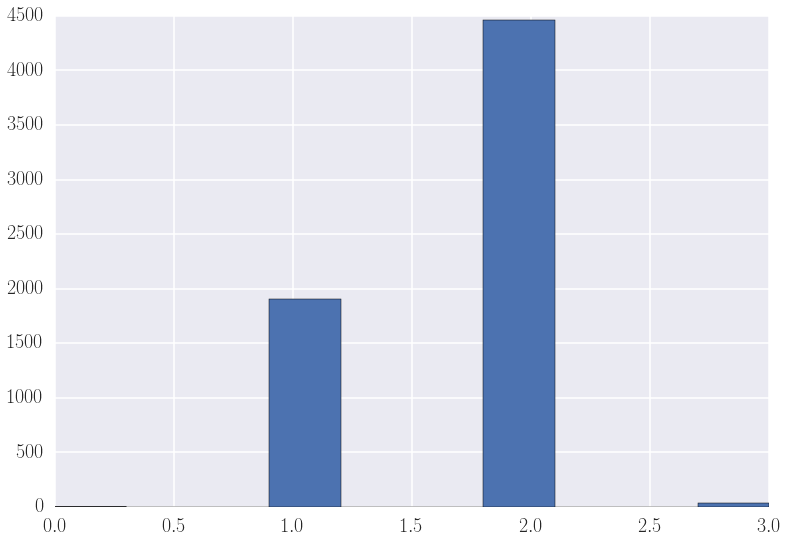

In [71]:
plt.hist(muffin.values())

Cool. The number of nodes touched are

In [72]:
len(muffin)

6408

## Miss Thing/Mary

In [73]:
searcher = BFS(sc, 'MISS THING/MARY', network_rdd)

In [74]:
for i in range(10):
    searcher.do_iteration()

In [75]:
thing_list = searcher.collected_distance_rdd

In [77]:
muffin = dict(thing_list)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

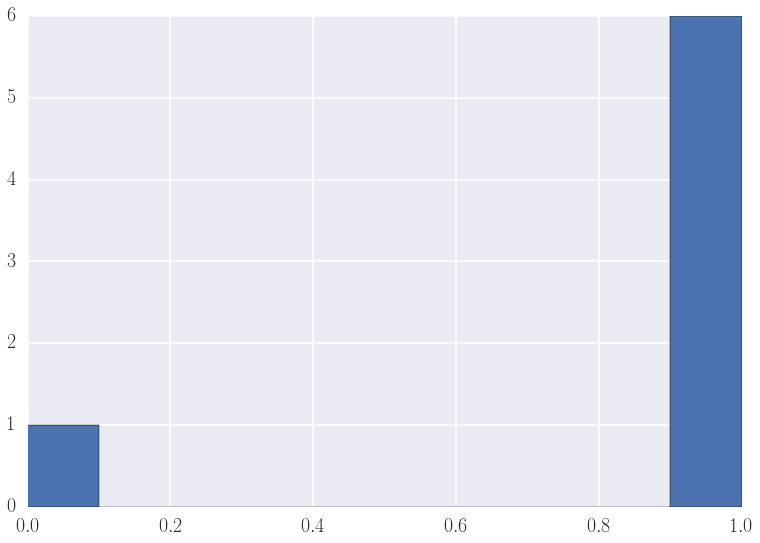

In [78]:
plt.hist(muffin.values())

In [79]:
len(muffin)

7

## Orwell

In [80]:
searcher = BFS(sc, 'ORWELL', network_rdd)

In [81]:
for i in range(10):
    searcher.do_iteration()

In [82]:
orwell_list = searcher.collected_distance_rdd

In [84]:
muffin = dict(orwell_list)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

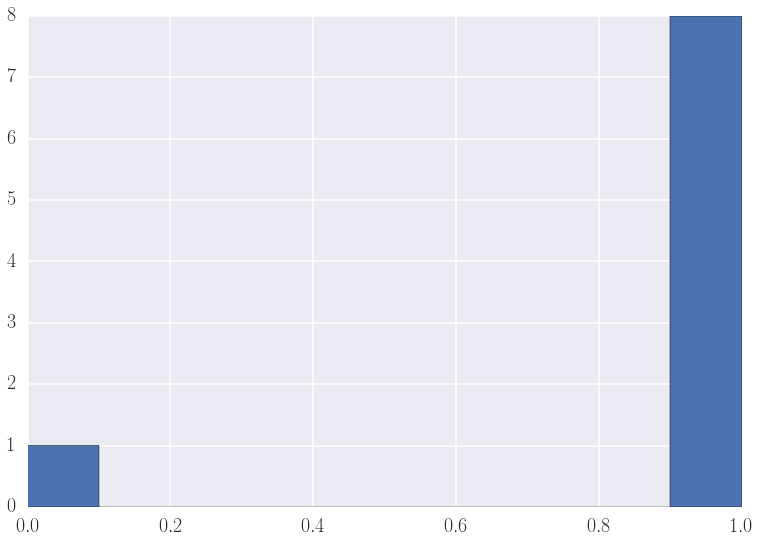

In [85]:
plt.hist(muffin.values())

In [86]:
len(orwell_list)

9

In [87]:
orwell_list

[(u'NILES, SEN. CATHERIN', 1),
 (u'ASHER, CARL', 1),
 (u'LUDLUM, ROSS', 1),
 (u'ASHER, MICHAEL', 1),
 (u'ORWELL', 0),
 (u'OSWALD', 1),
 (u'FAGIN', 1),
 (u'HOFFMAN', 1),
 (u'ASHER, DONNA', 1)]

Well, I think this is the first part of the problem. I don't really understand how to optimize with accumulators though. Also, let us write code to make the network converge.

In [113]:
network_rdd = network_rdd.cache()

In [116]:
network_rdd.is_cached

True

# Running until converged

In [117]:
searcher = BFS(sc, 'CAPTAIN AMERICA', network_rdd)

In [118]:
searcher.run_until_converged()

Finished at end of iteration 4 !


In [103]:
searcher = BFS(sc, 'ORWELL', network_rdd)

In [104]:
searcher.run_until_converged()

Finished at end of iteration 2 !


In [92]:
a={'a':1, 'b':2, 'c':3}
b = {'c':2, 'b':2, 'a':1, 'd':69}

In [ ]:
assert cmp